In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Load dataset

In [15]:
dataset = pd.read_csv('dataset/dev1_works_distance_dataset.csv')
y = dataset['label'].values
features = dataset.columns.difference(['label'])
X = dataset[features].values

## Split dataset by label (match|not_match) for visualisation

In [27]:
dataset_matched = dataset[dataset['label']==1]
dataset_not_matched = dataset[dataset['label']==0]

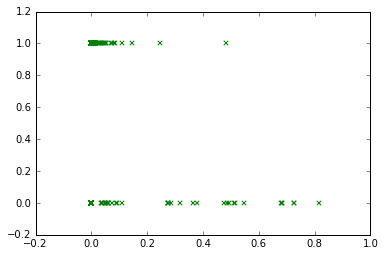

In [47]:
plt.scatter(dataset['title'].values, dataset['label'].values, color='green', marker='x', label='title')

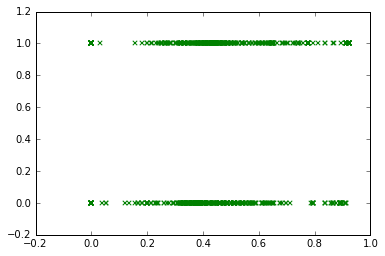

In [48]:
plt.scatter(dataset['idno'].values, dataset['label'].values, color='green', marker='x', label='title')

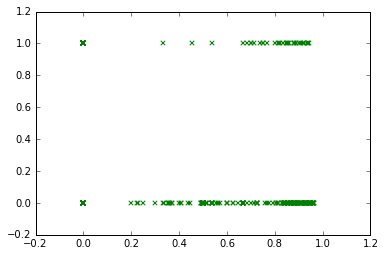

In [49]:
plt.scatter(dataset['subject'].values, dataset['label'].values, color='green', marker='x', label='title')

In [40]:
dataset_matched[features].mean()

contributor.name                  0.145189
contributor.role                  0.039686
country_of_publication            0.014500
idno                              0.397099
idno.type                         0.276245
language                          0.149333
publication_type                  0.001389
publisher.place_of_publication    0.113399
publisher.publisher_name          0.386482
publishing_work_items.type        0.005143
publishing_work_items.unit        0.005143
publishing_work_items.value       0.042134
subject                           0.057811
title                             0.003971
dtype: float64

In [41]:
dataset_not_matched[features].mean()

contributor.name                  0.313844
contributor.role                  0.108054
country_of_publication            0.162095
idno                              0.438359
idno.type                         0.398885
language                          0.229047
publication_type                  0.033550
publisher.place_of_publication    0.404530
publisher.publisher_name          0.397179
publishing_work_items.type        0.049553
publishing_work_items.unit        0.049553
publishing_work_items.value       0.392321
subject                           0.372889
title                             0.021495
dtype: float64

In [42]:
print(sum(dataset_matched[features].mean()))
print(sum(dataset_not_matched[features].mean()))

1.63752290745
3.37135550362
